# Preparar ambiente para execução
Baixar o dataset através do repositório no GitHub

In [1]:
%%shell
rm -r -f aibox
git clone https://github.com/fabioafreitas/aibox.git

Cloning into 'aibox'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 3), reused 26 (delta 1), pack-reused 0
Unpacking objects: 100% (31/31), done.


### Instalar pacotes necessários

In [2]:
!pip install numpy pandas xlrd xlsxwriter matplotlib scikit-learn tensorflow keras PyWavelets scipy

     |████████████████████████████████| 143kB 3.4MB/s 


### Efetuar Imports

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

from collections import OrderedDict
import xlrd
import xlsxwriter
import copy # copy.deepcopy - needed for non-shallow copy of odict object

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine learning imports
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import tensorflow as tf
import keras
from keras.layers import Dense, LSTM, Input, SimpleRNN
from keras.models import Sequential, Model

import pywt # PyWavelets
from scipy import signal


## Resultados
* mse: 0.00985973187308187
* rmse: 0.0992961825705393
* mape: 9.225103473376366
* mpe: 8.772768195695258
* mae: 0.06159478082277109

# Dataset

In [0]:
def split_dataset_train_test(dataset, train_size, test_size):
  begin_of_split = 0
  train_list = []
  test_list = []
  while begin_of_split + train_size + test_size <= dataset.shape[0]:
    
    train = dataset[begin_of_split:begin_of_split+train_size]
    test = dataset[begin_of_split+train_size:begin_of_split+train_size+test_size]

    begin_of_split += test_size

    train_list.append(train)
    test_list.append(test)
  
  return train_list, test_list


def split_dataset_train_test_simple(dataset, train_proportion):
  train_size = int(dataset.shape[0] * train_proportion)

  data_train = dataset[:train_size]
  data_test = dataset[train_size:]

  return data_train, data_test


def split_dataset_x_y(dataset):
  x_data = dataset.drop(columns='close')
  y_data = pd.DataFrame(dataset['close'])

  return x_data, y_data


def wavelet_reconst_l2(data):
    coeffs = pywt.wavedec(data, 'haar', level=2)
    reconstructed_signal = pywt.waverec(coeffs, 'haar', mode = 'per')
    return reconstructed_signal


# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# https://www.dataquest.io/blog/understanding-regression-error-metrics/
def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( (y_true - y_pred) / y_true) * 100



Beginning training of layer #1

Epoch 1/100
2010/2010 [==============================] - 1s 397us/step - loss: 0.0803
Epoch 2/100
2010/2010 [==============================] - 0s 123us/step - loss: 0.0538
Epoch 3/100
2010/2010 [==============================] - 0s 107us/step - loss: 0.0385
Epoch 4/100
2010/2010 [==============================] - 0s 90us/step - loss: 0.0293
Epoch 5/100
2010/2010 [==============================] - 0s 94us/step - loss: 0.0247
Epoch 6/100
2010/2010 [==============================] - 0s 115us/step - loss: 0.0225
Epoch 7/100
2010/2010 [==============================] - 0s 142us/step - loss: 0.0214
Epoch 8/100
2010/2010 [==============================] - 0s 116us/step - loss: 0.0206
Epoch 9/100
2010/2010 [==============================] - 0s 115us/step - loss: 0.0199
Epoch 10/100
2010/2010 [==============================] - 0s 96us/step - loss: 0.0192
Epoch 11/100
2010/2010 [==============================] - 0s 98us/step - loss: 0.0185
Epoch 12/100
2010/2010 

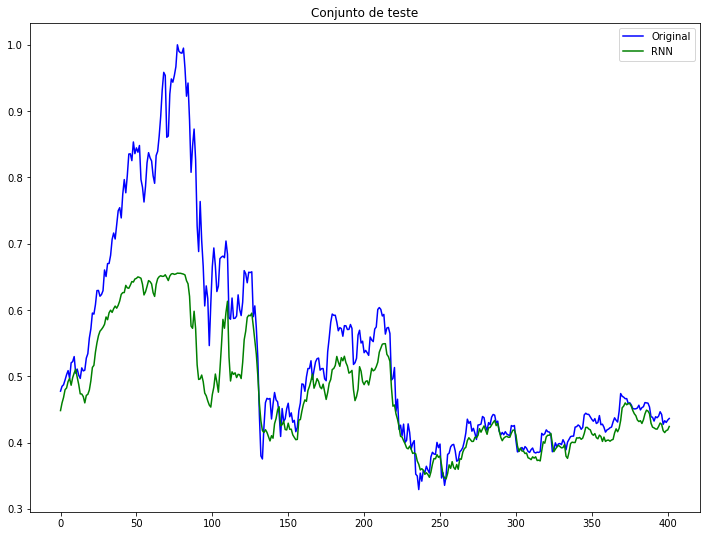

model performance:
mse: 0.00985973187308187 rmse: 0.0992961825705393 mape: 9.225103473376366 mpe: 8.772768195695258 mae: 0.06159478082277109


'\n\nEND OF MODEL EVALUATION\n\n'

In [8]:
"""

DATASET PREPARATION

"""

# Carregar de um arquivo excel e mapear cada planilha para um ordered dict
raw_xlsx_file = pd.ExcelFile("aibox/dataset/dataset.xlsx")
dict_dataframes = pd.read_excel(raw_xlsx_file,sheet_name = None)

# Criar um novo dict de dataframes para as planilhas futures
dict_dataframes_future = copy.deepcopy(dict_dataframes)
# Criar um novo dict de dataframes para as planilhas index
dict_dataframes_index =  copy.deepcopy(dict_dataframes)

# Remover planilhas index do dict com as planilhas future
del dict_dataframes_future['csi300 index data']
del dict_dataframes_future['nifty 50 index data']
del dict_dataframes_future['hangseng index data']
del dict_dataframes_future['s&p500 index data']
del dict_dataframes_future['nikkei 225 index data']
del dict_dataframes_future['djia index data']

# Remover planilhas futures do dict com as planilhas index
del dict_dataframes_index['csi300 index future data']
del dict_dataframes_index['nifty 50 index future data']
del dict_dataframes_index['hangseng index future data']
del dict_dataframes_index['s&p500 index future data']
del dict_dataframes_index['nikkei 225 index future data']
del dict_dataframes_index['djia index future data']

index_name = 'csi300 index data'
# Converter a coluna date para um objeto datetime para plot do gráfico
dict_dataframes_index[index_name]['date'] = pd.to_datetime(dict_dataframes_index[index_name]['date'].astype(str), format='%Y-%m-%d')
# Definir a coluna data como índice do dataframe
dict_dataframes_index[index_name] = dict_dataframes_index[index_name].set_index('date')

# Normalização dos dados
index_backup = dict_dataframes_index[index_name].index.copy()
columns_names = dict_dataframes_index[index_name].columns
min_max_scaler = preprocessing.MinMaxScaler()
dict_dataframes_index[index_name] = min_max_scaler.fit_transform(dict_dataframes_index[index_name])
dict_dataframes_index[index_name] = pd.DataFrame(dict_dataframes_index[index_name], columns=columns_names)
dict_dataframes_index[index_name].index = index_backup

"""

WAVELET TRANSFORMATION

"""
# Wavelet Transformation em todo a coluna de close
dict_dataframes_index[index_name]['close'] = wavelet_reconst_l2(dict_dataframes_index[index_name]['close'])
"""

END OF WAVELET TRANSFORMATION

"""
"""

AUTOENCODER

"""
dataset = dict_dataframes_index[index_name].drop(columns=['close']) # remove the output
# Parâmetros das camadas
input_dim = dataset.shape[1]
hidden_dim = 10
activation_function = 'sigmoid'
train_epochs = 100
# Modelo
stacked_autoencoder = Sequential()

# camada #1
# Entrada e Primeira camada interna
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function, input_shape=(input_dim,)) )
# Camada de saída
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #1\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #2
# Remover camada de decoder do primeiro AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #2\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #3
# Remover camada de decoder do segundo AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #3\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)

# Camada #4
# Remover camada de decoder do terceiro AE
stacked_autoencoder.pop()
# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False
# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )
stacked_autoencoder.compile(optimizer='adam', loss='mse')
# Treinamento
print('\nBeginning training of layer #4\n')
stacked_autoencoder.fit(dataset, dataset, epochs=train_epochs)
"""

END OF AUTOENCODER MODELLING AND TRAINING

"""

# Get output from the stacked autoencoder
close_column_backup = dict_dataframes_index[index_name]['close'].copy().values
dict_dataframes_index[index_name] = dict_dataframes_index[index_name].drop(columns=['close'])
column_backup = dict_dataframes_index[index_name].columns.copy()
dict_dataframes_index[index_name] = stacked_autoencoder.predict(dict_dataframes_index[index_name])
dict_dataframes_index[index_name] = pd.DataFrame(dict_dataframes_index[index_name])
dict_dataframes_index[index_name].columns = column_backup
dict_dataframes_index[index_name]['close'] = close_column_backup


# Split treino e teste do dataset, observando a restrição de séries temporais
train_data, test_data = split_dataset_train_test_simple(dict_dataframes_index[index_name], train_proportion=0.8)

# Split entrada e saída do dataset treino
x_data_train, y_data_train = split_dataset_x_y(train_data)

x_data_train = np.reshape(x_data_train.values, (x_data_train.shape[0], x_data_train.shape[1], 1))
# y_data_train = np.reshape(y_data_train.values, (y_data_train.shape[0], y_data_train.shape[1], 1))


# Split entrada e saída do dataset teste
x_data_test, y_data_test = split_dataset_x_y(test_data)

x_data_test = np.reshape(x_data_test.values, (x_data_test.shape[0], x_data_test.shape[1], 1))
# y_data_test = np.reshape(y_data_test.values, (y_data_test.shape[0], y_data_test.shape[1], 1))


"""

RNN MODELLING AND TRAINING

"""
print('\nBeginning of RNN training:\n')
# print(x_data_train.shape)
# print(y_data_train.shape)
# print(x_data_test.shape)
# print(y_data_test.shape)

predictor = Sequential()
# Adicionar camada RNN
neurons_rnn = 50
predictor.add( SimpleRNN(neurons_rnn, input_shape=(x_data_train.shape[1], x_data_train.shape[2])) )
# Adicionar camada de output
predictor.add( Dense(1) )
predictor.compile(optimizer='adam', loss='mse')
# predictor.summary()
# Treinamento
epochs_number = 40
predictor.fit(x_data_train, y_data_train, epochs=epochs_number)
"""

END OF RNN MODELLING AND TRAINING

"""
"""

MODEL EVALUATION

"""
# Usar o modelo para predizer no conjunto de teste
predicted_value = predictor.predict(x_data_test)

# Fazer um plot do resultado
plt.figure(figsize=(12,9))
plt.title('Conjunto de teste')
plt.plot(y_data_test.values, 'blue', label='Original')
plt.plot(predicted_value, 'green', label='RNN')
plt.legend()
plt.savefig('rnn_vs_original_test_set')
plt.show()

# Calcular as métricas
rnn_mse = mean_squared_error(y_data_test.values, predicted_value)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mape = mean_absolute_percentage_error(y_data_test.values, predicted_value)
rnn_mpe =  mean_percentage_error(y_data_test.values, predicted_value)
rnn_mae = mean_absolute_error(y_data_test.values, predicted_value)

print(40*'=')
print('model performance:')
print('mse:', rnn_mse, 'rmse:', rnn_rmse, 'mape:', rnn_mape, 'mpe:', rnn_mpe, 'mae:', rnn_mae)

# Salvar modelos
stacked_autoencoder.save('model_sae.h5')
predictor.save('model_rnn.h5')

f = open('predicted_value.txt', 'w')
f.write(str(predicted_value))
f.close()

f = open('original_value.txt', 'w')
f.write(str(y_data_test.values))
f.close()

f = open('metrics_result.txt', 'w')
f.write('mse: '+str(rnn_mse)+' rmse: '+str(rnn_rmse)+' mape: '+str(rnn_mape)+' mpe: '+str(rnn_mpe)+' mae: '+str(rnn_mae))
f.close()
"""

END OF MODEL EVALUATION

"""

#### Model performance

In [0]:
# Calcular as métricas
rnn_mse = mean_squared_error(y_data_test.values, predicted_value)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mape = mean_absolute_percentage_error(y_data_test.values, predicted_value)
rnn_mpe =  mean_percentage_error(y_data_test.values, predicted_value)
rnn_mae = mean_absolute_error(y_data_test.values, predicted_value)

print(40*'=')
print('model performance:')
print('mse:', rnn_mse, 'rmse:', rnn_rmse, 'mape:', rnn_mape, 'mpe:', rnn_mpe, 'mae:', rnn_mae)

model performance:
mse: 0.010920443940664265 rmse: 0.10450092794164205 mape: 10.457935389870164 mpe: 10.18161019073595 mae: 0.06793110826330465


In [0]:
f = open('predicted_value.txt', 'w')
f.write(str(predicted_value))
f.close()

f = open('original_value.txt', 'w')
f.write(str(y_data_test.values))
f.close()

f = open('metrics_result.txt', 'w')
f.write('mse: '+str(rnn_mse)+' rmse: '+str(rnn_rmse)+' mape: '+str(rnn_mape)+' mpe: '+str(rnn_mpe)+' mae: '+str(rnn_mae))
f.close()

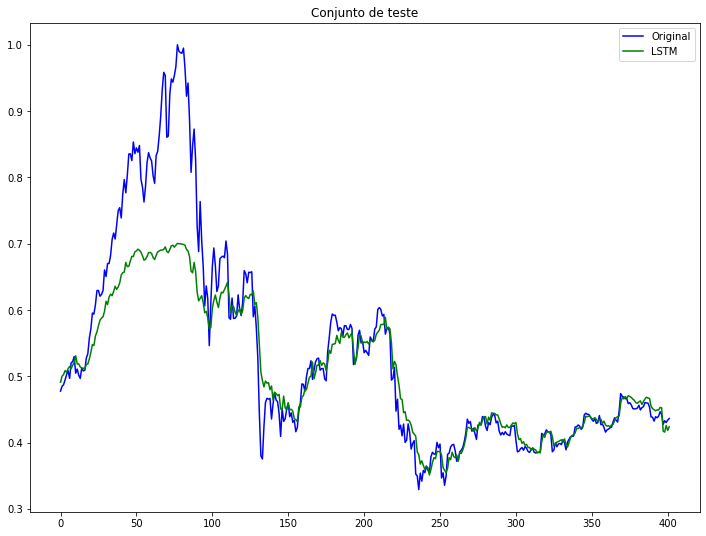

In [0]:
predicted_value = predictor.predict(x_data_test)

# Fazer um plot do resultado
plt.figure(figsize=(12,9))
plt.title('Conjunto de teste')
plt.plot(y_data_test.values, 'blue', label='Original')
plt.plot(predicted_value, 'green', label='RNN')
plt.legend()
plt.savefig('rnn_vs_original_test_set')
plt.show()